In [1]:
import json
import glob
import os
from collections import Counter
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Libertine', 'Times New Roman']
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
get_dataset = lambda x: os.path.basename(x).split('.')[0]
get_method = lambda x: '.'.join(os.path.basename(x).split('.')[1:-2])
get_ref_path = lambda d: os.path.join(
    os.environ['PATH_AKE_DATASETS'], 'datasets', d, 'references', 'test.{}.stem.json'.format(reference[d]))

In [3]:
def load_n_flatten_set(fp, n=None):
    # Load ref, select top-n, flatten and turn into set
    if isinstance(n, int):
        n = [n]
    with open(fp) as f:
        ref = json.load(f)
        if n:
            ref = {i: {k: set(va for kp in v[:i] for va in kp) for k, v in ref.items()} for i in n}
        else:
            ref = {k: set(va for kp in v for va in kp) for k, v in ref.items()}
    return ref

In [4]:
def display_heatmap(df, order, value='inter10', ax=None, **kwargs):
    ttmp = df.groupby(['method_a', 'method_b'])[value].mean()\
         .unstack().reindex(columns=order).reindex(order).apply(lambda x: round(x, 1))
    ttmp.index.name = ''
    ttmp.columns.name = ''
    fig = sns.heatmap(ttmp, square=True, annot=True,
                      linewidths=.1, cmap=sns.cubehelix_palette(8, start=3, rot=-.5),
                      **kwargs)
    for label in fig.axes.xaxis.get_majorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")
    return fig

### Init

In [5]:
root_bench = '../../ake-benchmarking/'
files = glob.glob(root_bench + 'output/*/*.stem.json')
# methods = sorted(set(map(get_method, files)))
# datasets = sorted(set(map(get_dataset, files)))
methods = [
    #'FirstPhrases', 'TextRank', 'TfIdf',
    #'PositionRank', 'MultipartiteRank', 'EmbedRank',
    #'Kea',
    'CopyRNN', 'CopyCorrRNN' ,
    'CopyRNN_News', 'CopyCorrRNN_News'
]
dataset = [
    'PubMed', 'ACM', 'SemEval-2010',
    'Inspec', 'WWW', 'KP20k',
    'DUC-2001', '500N-KPCrowd','NYTime'
    #'WikinewsKeyphrase', 'TermITH-Eval', 'NUS', 'NTCIR1+2', 'KDD', 'JPTime', 'Citeulike-180', 'CSTR', 'KPTimes', '110-PT-BN-KP',
]
files = [f for f in files if get_method(f) in methods and get_dataset(f) in dataset]

In [7]:
reference = {
'CSTR': 'author',
'NUS': 'combined',
'PubMed': 'author',
'ACM': 'author',
'ACM-abstract': 'author',
'Citeulike-180': 'reader',
'SemEval-2010': 'combined',
'SemEval-2010-abstract': 'combined',
'Inspec': 'uncontr',
'KDD': 'author',
'WWW': 'author',
'TermITH': 'indexer',
'KP20k': 'author',
'DUC-2001': 'reader',
'110-PT-BN-KP': 'reader',
'500N-KPCrowd': 'reader',
'WikinewsKeyphrase': 'reader',
'NYTime': 'author'}

In [8]:
if os.path.exists('cache.csv'):
    df = pd.read_csv('cache.csv')

In [9]:
df.shape

(963, 12)

In [192]:
data = []

for i, p_a in enumerate(tqdm(files)):
    d = get_dataset(p_a)
    kp_a = load_n_flatten_set(p_a, n=[5, 10, 20])
    # Load ref
    # filter good keyphrases
    ref = load_n_flatten_set(get_ref_path(d))
    good_kp_a = {key: value & ref[key] for key, value in kp_a[10].items()}
    bad_kp_a = {key: value - ref[key] for key, value in kp_a[10].items()}

    for j, p_b in enumerate(files):
        if j < i:
            continue
        if get_dataset(p_b) != d:
            continue
        # p_b is Same dataset other method
        kp_b = load_n_flatten_set(p_b, n=[5, 10])
        # Load ref
        # filter good keyphrases
        good_kp_b = {key: value & ref[key] for key, value in kp_b[10].items()}
        bad_kp_b = {key: value - ref[key] for key, value in kp_b[10].items()}
        
        nb_doc = len(kp_a[10])

        inter10 = sum(len(kp_a[10][k] & kp_b[10][k]) for k in kp_a[10]) / nb_doc
        inter5 = sum(len(kp_a[5][k] & kp_b[5][k]) for k in kp_a[5]) / nb_doc
        
        if i == j:
            rappel5 = sum(len(kp_a[10][k] & ref[k]) / len(ref[k]) for k in kp_a[10]) / nb_doc
            rappel10 = sum(len(kp_a[20][k] & ref[k]) / len(ref[k]) for k in kp_a[20]) / nb_doc
        else:
            rappel5 = sum(len((kp_a[5][k] | kp_b[5][k]) & ref[k]) / len(ref[k]) for k in kp_a[5]) / nb_doc
            rappel10 = sum(len((kp_a[10][k] | kp_b[10][k]) & ref[k]) / len(ref[k]) for k in kp_a[10]) / nb_doc
        
        good_inter = sum(len(good_kp_a[k] & good_kp_b[k]) for k in good_kp_a) / nb_doc
        bad_inter = sum(len(bad_kp_a[k] & bad_kp_b[k]) for k in bad_kp_a) / nb_doc

        data.append([d, get_method(p_a), get_method(p_b), nb_doc, inter5, inter10, rappel5, rappel10, good_inter, bad_inter])
        if i != j:
            data.append([d, get_method(p_b), get_method(p_a), nb_doc, inter5, inter10, rappel5, rappel10, good_inter, bad_inter])
        

100%|██████████| 93/93 [04:30<00:00,  2.91s/it]


In [123]:
# Create DataFrame
cols = ['dataset', 'method_a', 'method_b', 'nb_doc', 'inter5', 'inter10',
        'rappel5', 'rappel10', 'good_inter', 'bad_inter']


df = pd.DataFrame(data, columns=cols)
# Init dataframe
df['type'] = ''
df.loc[df['dataset'].isin(['DUC-2001', '500N-KPCrowd', 'NYTime']),'type'] = 'news'
df.loc[df['dataset'].isin(['Inspec', 'WWW', 'KP20k']),'type'] = 'abstract'
df.loc[df['dataset'].isin(['PubMed', 'ACM', 'SemEval-2010']),'type'] = 'full'
map_method = {'MultipartiteRank': 'MPRank', 'CopyCorrRNN': 'CorrRNN', 'CopyCorrRNN_News': 'CorrRNN_News'}
df['method_a'] = df['method_a'].apply(lambda x: map_method.get(x, x))
df['method_b'] = df['method_b'].apply(lambda x: map_method.get(x, x))
df.to_csv('cache.csv')

### Compute Intersection between output keywords

In [143]:
df[df['method_a'] == df['method_b']][df['method_a'] == 'TextRank']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,dataset,method_a,method_b,nb_doc,inter5,inter10,rappel5,rappel10,good_inter,bad_inter,type
96,DUC-2001,TextRank,TextRank,308,4.99026,9.928571,0.808442,1.496753,1.496753,8.431818,news
217,Inspec,TextRank,TextRank,500,4.99800,9.884000,1.966000,3.476000,3.476000,6.408000,abstract
285,WWW,TextRank,TextRank,1330,4.85188,9.529323,0.294737,0.596241,0.596241,8.933083,abstract
385,KP20k,TextRank,TextRank,20000,4.99820,9.963000,0.368400,0.764400,0.764400,9.198600,abstract
505,SemEval-2010,TextRank,TextRank,100,5.00000,10.000000,0.200000,0.420000,0.420000,9.580000,full
521,PubMed,TextRank,TextRank,1320,5.00000,10.000000,0.062879,0.136364,0.136364,9.863636,full
693,500N-KPCrowd,TextRank,TextRank,50,5.00000,10.000000,0.700000,1.540000,1.540000,8.460000,news
782,NYTime,TextRank,TextRank,10000,5.00000,9.991100,0.088800,0.200400,0.200400,9.790700,news
882,ACM,TextRank,TextRank,2304,5.00000,10.000000,0.076389,0.191840,0.191840,9.808160,full


In [144]:
filt_same = ~(df['method_a'] == df['method_b'])

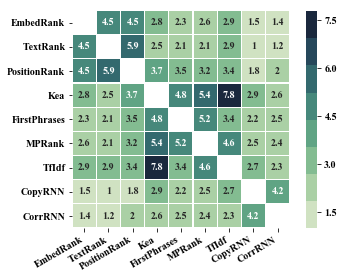

In [175]:
disp_methods = [
    'EmbedRank','TextRank', 'PositionRank',
    'Kea', 'FirstPhrases', 'MPRank', 'TfIdf',
    'CopyRNN', 'CorrRNN']
fig = display_heatmap(df[filt_same], disp_methods)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


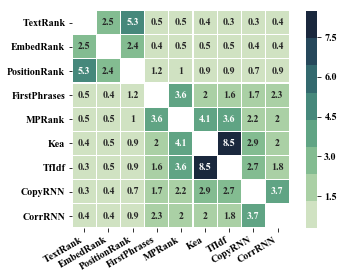

In [176]:
full_methods = [
    'TextRank', 'EmbedRank', 'PositionRank',
    'FirstPhrases', 'MPRank', 'Kea',  'TfIdf',
    'CopyRNN', 'CorrRNN']
display_heatmap(df[filt_same][df['type'] == 'full'], full_methods)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


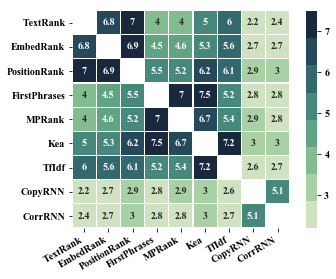

In [147]:
abstract_methods = [
    'TextRank', 'EmbedRank','PositionRank',
    'FirstPhrases', 'MPRank', 'Kea', 'TfIdf', 
    'CopyRNN', 'CorrRNN']
display_heatmap(df[filt_same][df['type'] == 'abstract'], abstract_methods)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


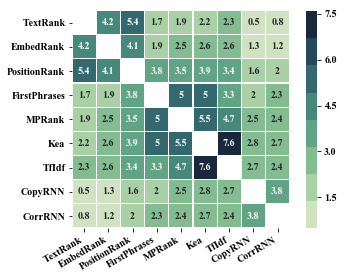

In [148]:
news_methods = [
    'TextRank', 'EmbedRank', 'PositionRank','FirstPhrases', 
     #'TfIdf', 'Kea','MPRank',
    'MPRank','Kea', 'TfIdf', 
    'CopyRNN', 'CorrRNN']
display_heatmap(df[filt_same][df['type'] == 'news'], news_methods)

In [185]:
# Remove CopyRNN and CorrRNN for News dataset and News version for non news dataset
df4 = df.drop(df[
    ((df['type'] == 'news') & (
        (df['method_a'].isin(['CopyRNN', 'CorrRNN'])) |
        (df['method_b'].isin(['CopyRNN', 'CorrRNN']))
    )) | ((df['type'] != 'news') & (
        (df['method_a'].isin(['CopyRNN_News', 'CorrRNN_News'])) |
        (df['method_b'].isin(['CopyRNN_News', 'CorrRNN_News']))
    ))].index)
df4 = df4[filt_same]
df4['method_a'] = df4['method_a'].apply(lambda x: x.replace('_News', ''))
df4['method_b'] = df4['method_b'].apply(lambda x: x.replace('_News', ''))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [183]:
disp_meth = ['TextRank', 'EmbedRank', 'PositionRank',
    'FirstPhrases', 'MPRank', 'Kea',  'TfIdf',
    'CopyRNN', 'CorrRNN']

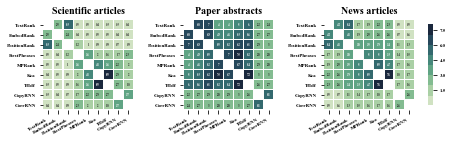

In [186]:
fig = plt.figure()

ax = fig.add_subplot(131)
display_heatmap(df4[df4['type'] == 'full'], disp_meth, vmin=0.001, vmax=8, cbar=False, ax=ax, annot_kws={'size': '3'})
ax.tick_params(labelsize=5)
ax.set_title('Scientific articles', fontsize=10, weight='ultralight')

ax = fig.add_subplot(132)
display_heatmap(df4[df4['type'] == 'abstract'], disp_meth, vmin=0.001, vmax=8, cbar=False, ax=ax, annot_kws={'size': '3'})
ax.tick_params(labelsize=5)
ax.set_title('Paper abstracts', fontsize=10)
new_ax = fig.add_axes([1, 0.36, .01, .28])

ax = fig.add_subplot(133)
display_heatmap(df4[df4['type'] == 'news'], disp_meth, vmin=0.001, vmax=8, cbar=True, ax=ax, cbar_ax=new_ax, annot_kws={'size': '3'})
ax.tick_params(labelsize=5)
ax.set_title('News articles', fontsize=10)
new_ax.tick_params(labelsize=5)

plt.tight_layout()
plt.savefig('../../../../Downloads/intersect.png', dpi=1080, bbox_inches='tight', transparent=True)

### Union of 2 model improves recall ?

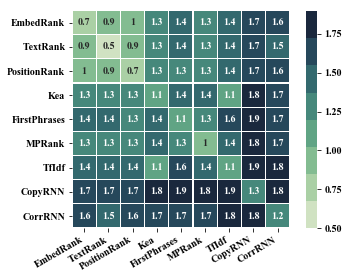

In [193]:
disp_methods = [
    'EmbedRank','TextRank', 'PositionRank',
    'Kea', 'FirstPhrases', 'MPRank', 'TfIdf',
    'CopyRNN', 'CorrRNN']
fig = display_heatmap(df, disp_methods, value='rappel5')

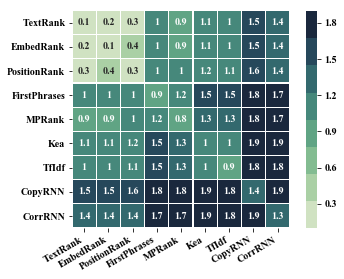

In [194]:
full_methods = [
    'TextRank', 'EmbedRank', 'PositionRank',
    'FirstPhrases', 'MPRank', 'Kea',  'TfIdf',
    'CopyRNN', 'CorrRNN']
display_heatmap(df[df['type'] == 'full'], full_methods, value='rappel5')

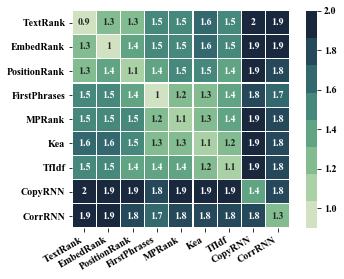

In [155]:
abstract_methods = [
    'TextRank', 'EmbedRank','PositionRank',
    'FirstPhrases', 'MPRank', 'Kea', 'TfIdf', 
    'CopyRNN', 'CorrRNN']
display_heatmap(df[df['type'] == 'abstract'], abstract_methods, value='rappel5')

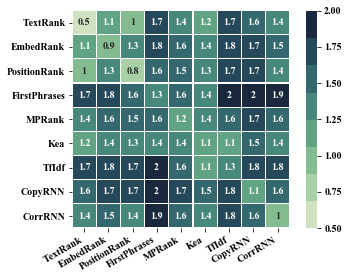

In [156]:
news_methods = [
    'TextRank', 'EmbedRank', 'PositionRank','FirstPhrases', 
     #'TfIdf', 'Kea','MPRank',
    'MPRank','Kea', 'TfIdf', 
    'CopyRNN', 'CorrRNN']
display_heatmap(df[df['type'] == 'news'], news_methods, value='rappel5')

In [195]:
# Remove CopyRNN and CorrRNN for News dataset and News version for non news dataset
df4 = df.drop(df[
    ((df['type'] == 'news') & (
        (df['method_a'].isin(['CopyRNN', 'CorrRNN'])) |
        (df['method_b'].isin(['CopyRNN', 'CorrRNN']))
    )) | ((df['type'] != 'news') & (
        (df['method_a'].isin(['CopyRNN_News', 'CorrRNN_News'])) |
        (df['method_b'].isin(['CopyRNN_News', 'CorrRNN_News']))
    ))].index)
df4['method_a'] = df4['method_a'].apply(lambda x: x.replace('_News', ''))
df4['method_b'] = df4['method_b'].apply(lambda x: x.replace('_News', ''))

In [196]:
disp_meth = ['TextRank', 'EmbedRank', 'PositionRank',
    'FirstPhrases', 'MPRank', 'Kea',  'TfIdf',
    'CopyRNN', 'CorrRNN']

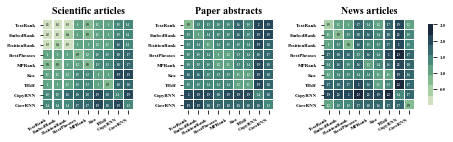

In [197]:
fig = plt.figure()

ax = fig.add_subplot(131)
display_heatmap(df4[df4['type'] == 'full'], disp_meth, value='rappel5', vmin=0.001, vmax=2.5, cbar=False, ax=ax, annot_kws={'size': '3'})
ax.tick_params(labelsize=5)
ax.set_title('Scientific articles', fontsize=10, weight='ultralight')

ax = fig.add_subplot(132)
display_heatmap(df4[df4['type'] == 'abstract'], disp_meth, value='rappel5', vmin=0.001, vmax=2.5, cbar=False, ax=ax, annot_kws={'size': '3'})
ax.tick_params(labelsize=5)
ax.set_title('Paper abstracts', fontsize=10)
new_ax = fig.add_axes([1, 0.36, .01, .28])

ax = fig.add_subplot(133)
display_heatmap(df4[df4['type'] == 'news'], disp_meth, value='rappel5', vmin=0.001, vmax=2.5, cbar=True, ax=ax, cbar_ax=new_ax, annot_kws={'size': '3'})
ax.tick_params(labelsize=5)
ax.set_title('News articles', fontsize=10)
new_ax.tick_params(labelsize=5)

plt.tight_layout()
plt.savefig('../../../../Downloads/rappel.png', dpi=1080, bbox_inches='tight', transparent=True)

### Compute intersect between GOOD keyphrase
To see which models make the same good thing

##### @5

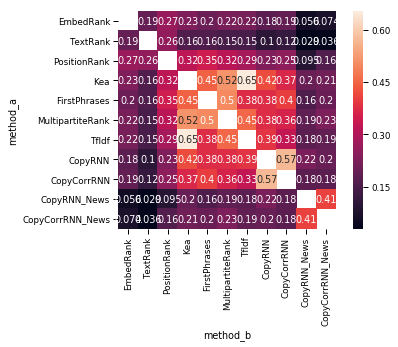

In [332]:
disp_methods = [
    'EmbedRank','TextRank', 'PositionRank',
    'Kea', 'FirstPhrases', 'MultipartiteRank', 'TfIdf',
    'CopyRNN', 'CopyCorrRNN', 'CopyRNN_News', 'CopyCorrRNN_News']
display_heatmap(df_pos, disp_methods, value='good_inter')

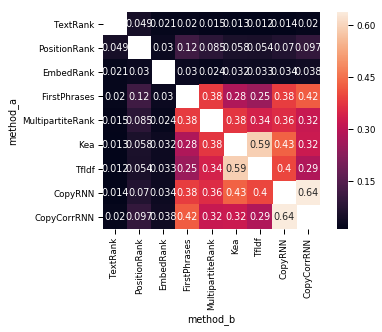

In [333]:
full_methods = [
    'TextRank', 'PositionRank','EmbedRank',
    'FirstPhrases', 'MultipartiteRank', 'Kea',  'TfIdf',
    'CopyRNN', 'CopyCorrRNN']
display_heatmap(df_pos[df_pos['type'] == 'full'], full_methods, value='good_inter')

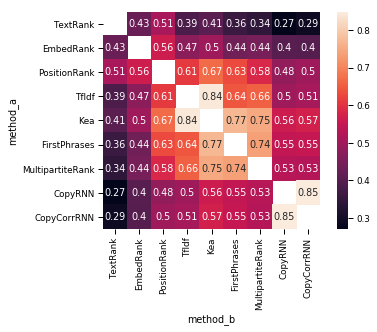

In [334]:
abstract_methods = [
    'TextRank', 'EmbedRank','PositionRank',
     'TfIdf', 'Kea', 'FirstPhrases', 'MultipartiteRank',
    'CopyRNN', 'CopyCorrRNN']
display_heatmap(df_pos[df_pos['type'] == 'abstract'], abstract_methods, value='good_inter')

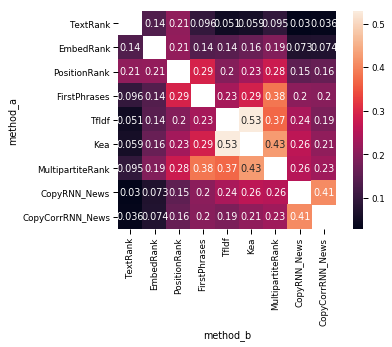

In [335]:
news_methods = [
    'TextRank', 'EmbedRank', 'PositionRank','FirstPhrases', 
     'TfIdf', 'Kea','MultipartiteRank',
    'CopyRNN_News', 'CopyCorrRNN_News']
display_heatmap(df_pos[df_pos['type'] == 'news'], news_methods, value='good_inter')

##### @10

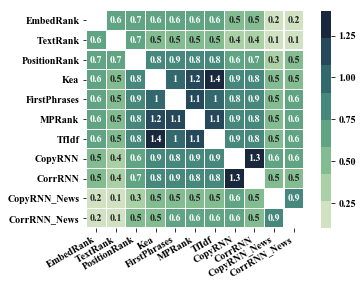

In [165]:
disp_methods = [
    'EmbedRank','TextRank', 'PositionRank',
    'Kea', 'FirstPhrases', 'MPRank', 'TfIdf',
    'CopyRNN', 'CorrRNN', 'CopyRNN_News', 'CorrRNN_News']
display_heatmap(df[filt_same], disp_methods, value='good_inter')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


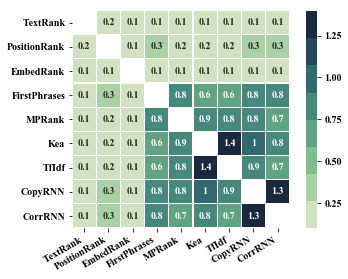

In [168]:
full_methods = [
    'TextRank', 'PositionRank','EmbedRank',
    'FirstPhrases', 'MPRank', 'Kea',  'TfIdf',
    'CopyRNN', 'CorrRNN']
display_heatmap(df[filt_same][df['type'] == 'full'], full_methods, value='good_inter')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


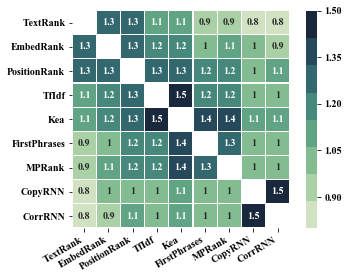

In [170]:
abstract_methods = [
    'TextRank', 'EmbedRank','PositionRank',
     'TfIdf', 'Kea', 'FirstPhrases', 'MPRank',
    'CopyRNN', 'CorrRNN']
display_heatmap(df[filt_same][df['type'] == 'abstract'], abstract_methods, value='good_inter')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


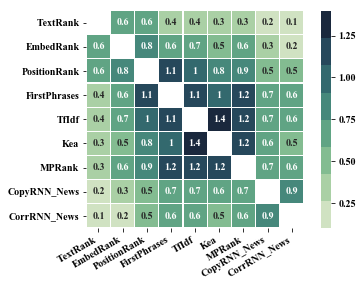

In [172]:
news_methods = [
    'TextRank', 'EmbedRank', 'PositionRank','FirstPhrases', 
     'TfIdf', 'Kea','MPRank',
    'CopyRNN_News', 'CorrRNN_News']
display_heatmap(df[filt_same][df['type'] == 'news'], news_methods, value='good_inter')

### Compute intersect between BAD keyphrase
To see which models make the same mistakes

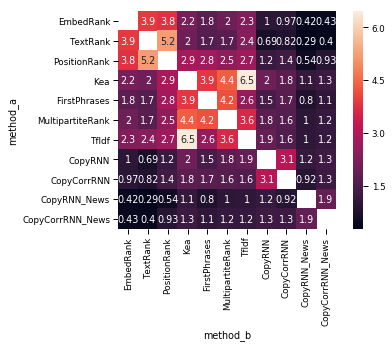

In [325]:
disp_methods = [
    'EmbedRank','TextRank', 'PositionRank',
    'Kea', 'FirstPhrases', 'MultipartiteRank', 'TfIdf',
    'CopyRNN', 'CopyCorrRNN', 'CopyRNN_News', 'CopyCorrRNN_News']
display_heatmap(df_pos, disp_methods, value='bad_inter')

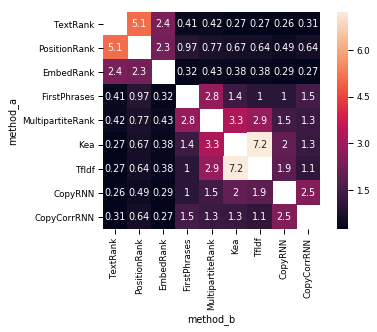

In [326]:
full_methods = [
    'TextRank', 'PositionRank','EmbedRank',
    'FirstPhrases', 'MultipartiteRank', 'Kea',  'TfIdf',
    'CopyRNN', 'CopyCorrRNN']
display_heatmap(df_pos[df_pos['type'] == 'full'], full_methods, value='bad_inter')

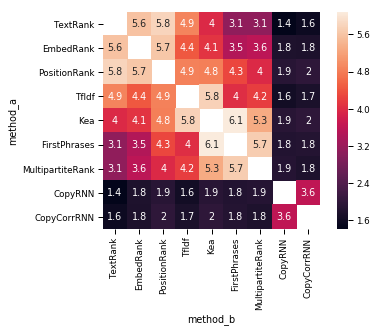

In [327]:
abstract_methods = [
    'TextRank', 'EmbedRank','PositionRank',
     'TfIdf', 'Kea', 'FirstPhrases', 'MultipartiteRank',
    'CopyRNN', 'CopyCorrRNN']
display_heatmap(df_pos[df_pos['type'] == 'abstract'], abstract_methods, value='bad_inter')

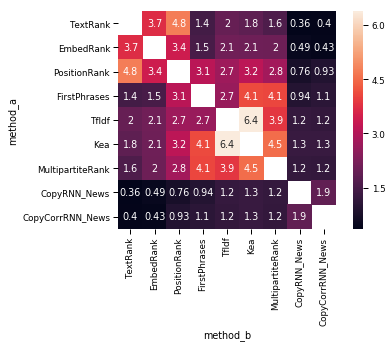

In [328]:
news_methods = [
    'TextRank', 'EmbedRank', 'PositionRank','FirstPhrases', 
     'TfIdf', 'Kea','MultipartiteRank',
    'CopyRNN_News', 'CopyCorrRNN_News']
display_heatmap(df_pos[df_pos['type'] == 'news'], news_methods, value='bad_inter')